First, load the data,in this notebook we are using the PMI data from the paper:"Environmental predictors impact microbialbased postmortem interval (PMI) estimation models within human decomposition soils". The preprocessed data includes OTU/phylum/class/order abundance matrices (includes or not include environmental factors)

In [1]:
import sys
sys.path.append('../Code')
import loadData 
import RunML
import RunML_continue
import FS
import metric

import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import pickle
import matplotlib.pyplot as plt

In [2]:
import glob
import os

In [3]:
PMIdata_path = '../Data/PMI/'

## No env model
16s (OTU/phylum/class/order) - no env

ITS (OTU/phylum/class/order) - no env

16s+ITS (OTU/phylum/class/order) - no env (only use this data when calculating H)
bact.ITS.n.class.env

### Data preprocess


In [4]:
bact_ITS_noenv_files = glob.glob(PMIdata_path + 'bact.ITS.n.*.noenv.csv')


In [5]:
bact_ITS_noenv_files

['../Data/PMI/bact.ITS.n.otu.noenv.csv',
 '../Data/PMI/bact.ITS.n.class.noenv.csv',
 '../Data/PMI/bact.ITS.n.order.noenv.csv',
 '../Data/PMI/bact.ITS.n.phylum.noenv.csv']

In [6]:
# Read each CSV file into a list of dataframes
bact_ITS_noenv_df_list = [pd.read_csv(file) for file in bact_ITS_noenv_files]

In [7]:
for df in bact_ITS_noenv_df_list:
    print(df.shape)

(78, 7415)
(78, 178)
(78, 412)
(78, 52)


In [8]:
data_4taxa = []
col_names_4taxa = []
for df in bact_ITS_noenv_df_list:
    data = df.drop(df.columns[0], axis=1)
    cols_name = data.columns.tolist()
    data = data.values
    data_4taxa.append(data)
    col_names_4taxa.append(cols_name)

In [9]:
# target variable
y = bact_ITS_noenv_df_list[3].iloc[:, 0].values 
y

array([   0.     , 1484.147  , 1989.56009, 2973.68   , 4027.69203,
          0.     , 1026.394  , 1423.473  ,  214.938  ,  493.696  ,
          0.     , 1543.201  , 2970.8    , 3542.968  ,    0.     ,
       1445.51502, 2962.59226, 3504.55394, 4583.2796 ,    0.     ,
       2639.949  , 3573.444  ,    0.     , 1507.78   , 3103.803  ,
       4567.716  ,    0.     , 1510.142  , 2847.791  , 4578.995  ,
          0.     , 1589.377  , 3031.373  , 4512.836  ,    0.     ,
       1502.226  , 3019.923  , 4574.528  ,    0.     , 1364.604  ,
       3009.054  , 3407.734  ,    0.     , 1530.639  , 2949.689  ,
       4391.578  ,    0.     , 1588.226  , 3011.635  , 3976.49   ,
          0.     , 1445.393  , 2999.732  , 4527.275  ,    0.     ,
       1532.17172, 3552.96112, 4474.30808,    0.     , 1329.627  ,
       2854.888  , 4326.392  ,    0.     , 1600.15   , 3024.861  ,
       3985.61   ,    0.     , 1087.43   , 1533.552  ,  510.076  ,
          0.     , 1500.02566, 2988.04838, 4447.32241,    0.  

In [10]:
# Define the threshold
y_threshold = 2500

# Categorize the series based on the threshold
y = np.where(y > y_threshold, 'LONG', 'SHORT')

print(y)

['SHORT' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'SHORT' 'SHORT'
 'SHORT' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG'
 'LONG' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT'
 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT'
 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG'
 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT'
 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT'
 'LONG' 'LONG' 'SHORT' 'SHORT' 'SHORT' 'SHORT' 'SHORT' 'SHORT' 'LONG'
 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG']


#### OTU

##### 1. calculate H statistics for OTU/phylum/class/order (both 16s and ITS)

In [11]:
weights_4taxa = []

In [12]:
for df in data_4taxa:
    data=FS.relative_abundance(df)
    print(np.shape(data))
    weights=FS.OTU_H_Score_fun(data,y)
    weights_4taxa.append(weights)
    

(78, 7414)
(78, 177)
(78, 411)
(78, 51)


In [13]:
for weight in weights_4taxa:
    print(len(weight))

7414
177
411
51


In [17]:
selectedOTU_index_4tax = []
eps_4tax = []

In [18]:
for weight in weights_4taxa:
    selectedOTU_index, eps=FS.indice_H_unisig(weight,y)
    print(eps)
    selectedOTU_index_4tax.append(selectedOTU_index)
    eps_4tax.append(eps)
    

23
26
34
13


##### 2. Select indices of the features based on H statistics and form the subset based on the selected features.
The default p value of the function is 10%, the resulted index is ranked by its H statistics descendingly.

Use "indice_H_unisig" if there is only one response, use "indice_H_multisig" for multiple responses.

weights_4taxa,selectedOTU_index_4tax,col_names_4taxa,eps_4tax

In [19]:
weights_sig_sorted_4taxa = []
col_names_sig_sorted_4taxa = []
for i in range(len(weights_4taxa)):
    weights_sig_sorted = weights_4taxa[i][selectedOTU_index_4tax[i]]
    col_names_sig_sorted = [col_names_4taxa[i][j] for j in selectedOTU_index_4tax[i]]
    weights_sig_sorted_4taxa.append(weights_sig_sorted)
    col_names_sig_sorted_4taxa.append(col_names_sig_sorted)

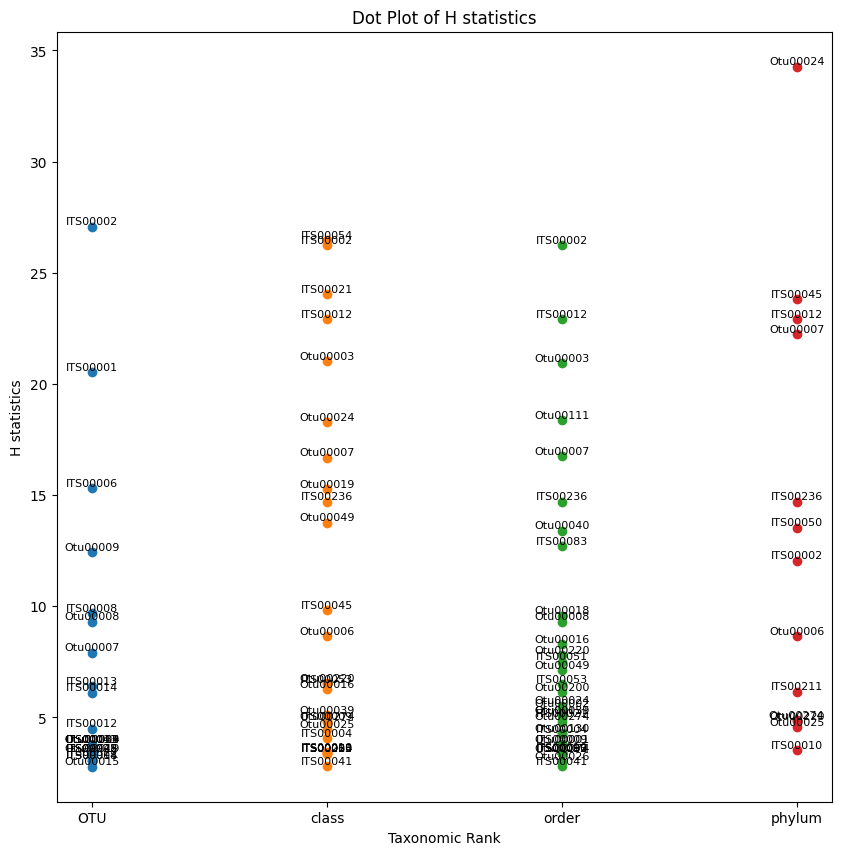

In [20]:
taxlabels = ['OTU', 'class', 'order', 'phylum']

# Assuming weights_sig_sorted_4taxa contains numeric arrays
# Ensure col_names_sig_sorted_4taxa contains the corresponding string labels for each point

plt.figure(figsize=(10, 10))
for i, array in enumerate(weights_sig_sorted_4taxa):
    x_values = [taxlabels[i]] * len(array)  # Label each point with its group (e.g., 'OTU', 'class', etc.)
    plt.scatter(x_values, array, label=f'{taxlabels[i]}')
    
    # Annotate each point with its name from col_names_sig_sorted_4taxa[i][j] and its value
    for j, z in enumerate(array):
        label = col_names_sig_sorted_4taxa[i][j]  # Get the corresponding label for this point
        plt.text(taxlabels[i], z, label, ha='center', va='bottom', fontsize=8, color='black')

plt.title('Dot Plot of H statistics')
plt.xlabel('Taxonomic Rank')
plt.ylabel('H statistics')
plt.show()

In [104]:
#plot the h statistics and cutoff descendingly
#for i in range(len(weights_4taxa)):
    #FS.plotWeightedIndex(weights_4taxa[i],threshold=eps_4tax[i])

In [21]:
data_4taxa[0]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.49850550e+02, 1.24158862e+01, 1.53282546e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.28043143e+01, 1.23266564e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.93780204e+01, 1.49358551e+03, 1.56450996e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.76288607e+02, 1.57368583e+02, 1.15054203e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.92171115e+01, 3.91444266e+02, 5.54846585e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

#### 4. Model
Prepare 4 datasets: full dataset, our selected dataset, Lasso selected  dataset(based on the target variable), randomly selected data (selected the same numer of variables as in our method)

Use random forest and SVM as classifier, and will build both models for each response variable.

For Lasso, the dataset will be determined by the response variable, so the lasso subset is different for the models for different response variables.

For random selection, the  process will repeat iter=30 times to  find the mean accuracy and AUC

SMOTE  is used (the data is not balanced, as we can see the performance is really bad especially for SVM model when not using SMOTE)

In [22]:
iter =30
cls = ["RF","SVM"]

In [23]:
targetLabel=y

In [24]:
data_subset_4taxa = []
X_lasso_4taxa = []
xlabel_lasso_4taxa = []
for i, data  in enumerate(data_4taxa):
    X_lasso,xlabel_lasso = RunML_continue.LassoFeatureSelection(data,targetLabel)
    X_lasso_4taxa.append(X_lasso_4taxa)
    xlabel_lasso_4taxa.append(xlabel_lasso)
    data_subset = {"AllFeatures":data, 
               "SelectMicro": data[:,selectedOTU_index_4tax[i]],
               "Lasso":X_lasso,
               "Random":data
              }
    data_subset_4taxa.append(data_subset)

In [25]:
for dataset  in data_subset_4taxa:
    data_subset = dataset
    for datatype, subset in data_subset.items():
        print(np.shape(subset))

(78, 7414)
(78, 23)
(78, 40)
(78, 7414)
(78, 177)
(78, 26)
(78, 24)
(78, 177)
(78, 411)
(78, 34)
(78, 22)
(78, 411)
(78, 51)
(78, 13)
(78, 10)
(78, 51)


In [119]:
#with open('../Data/PMI/data_subset_4taxa_noenv.pkl', 'wb') as file:
#    pickle.dump(data_subset_4taxa, file)


The  function will print out the accuracy and AUC for each dataset using each classifier, and also will return the y_actual, y_predict, y_predprob for future use.

In [40]:
#dict_cm = RunML_continue.runClassifier_FScompare(data_subsets= data_subset,y= targetLabel,N=iter,classifiers=cls)

### compare the first 15 index by their present ratio

['ITS00002', 'ITS00001', 'ITS00006', 'Otu00009', 'ITS00008', 'Otu00008', 'Otu00007', 'ITS00013', 'ITS00014', 'ITS00012']
35 43


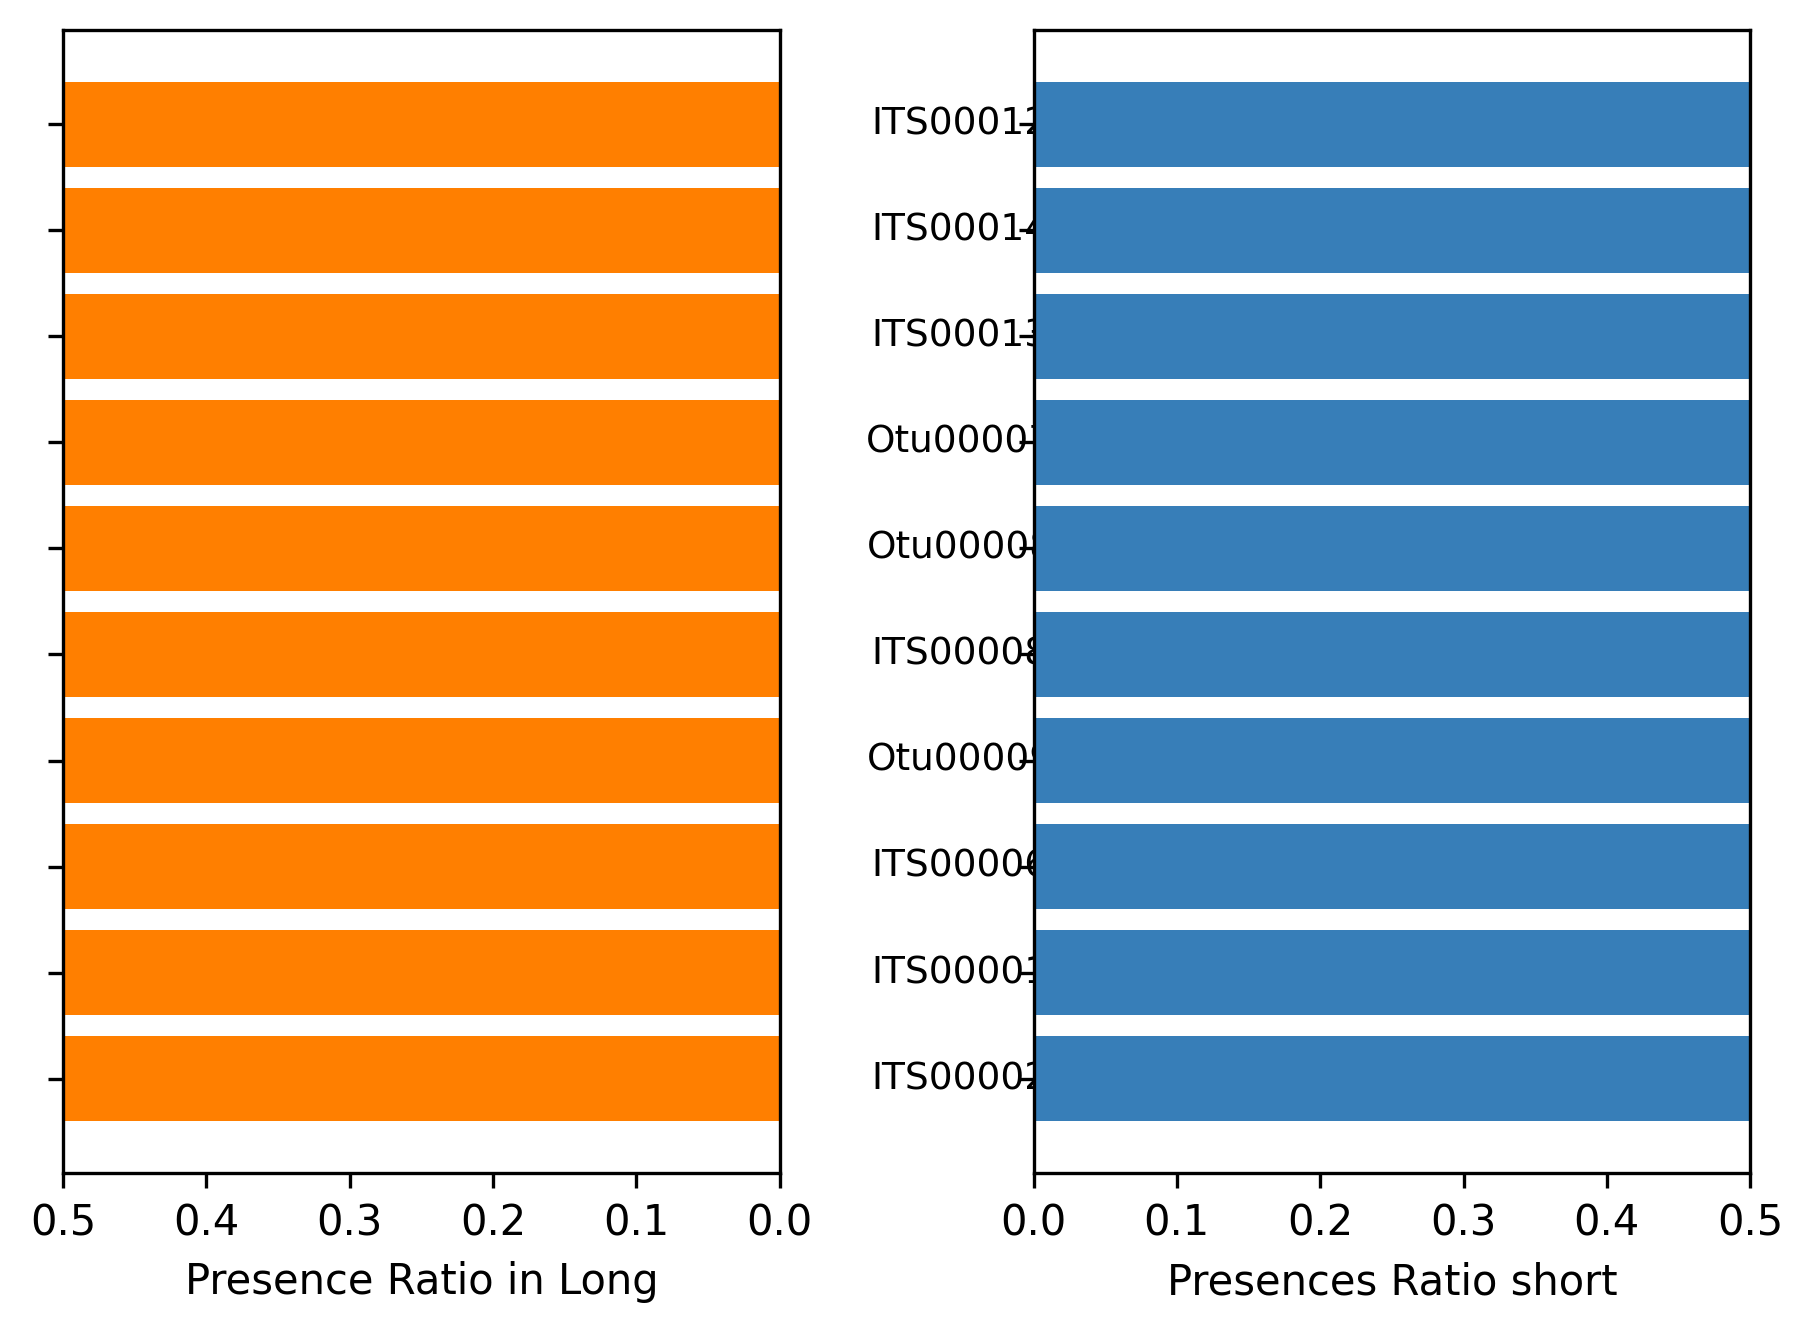

['ITS00054', 'ITS00002', 'ITS00021', 'ITS00012', 'Otu00003', 'Otu00024', 'Otu00007', 'Otu00019', 'ITS00236', 'Otu00049']
35 43


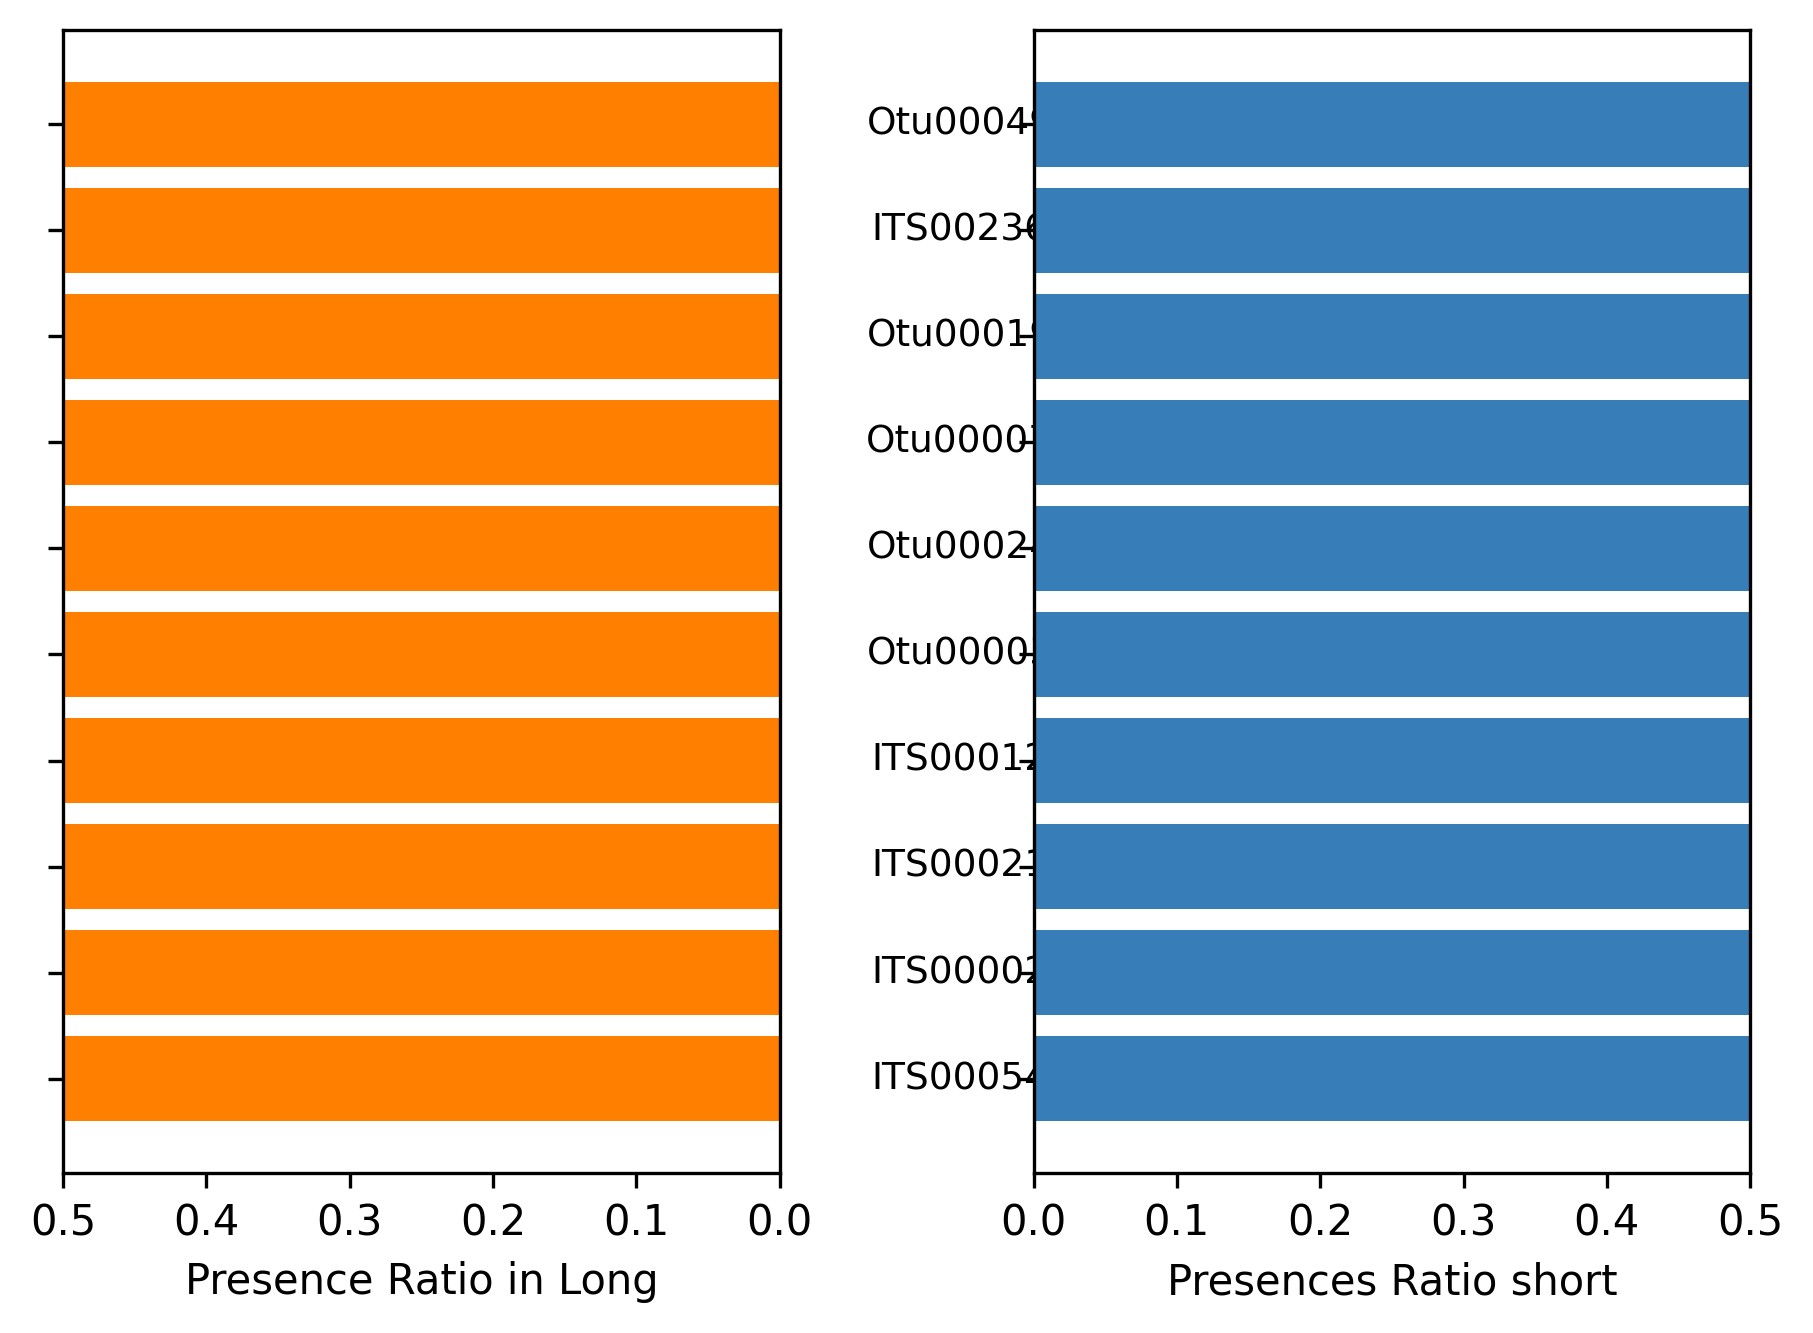

['ITS00002', 'ITS00012', 'Otu00003', 'Otu00111', 'Otu00007', 'ITS00236', 'Otu00040', 'ITS00083', 'Otu00018', 'Otu00008']
35 43


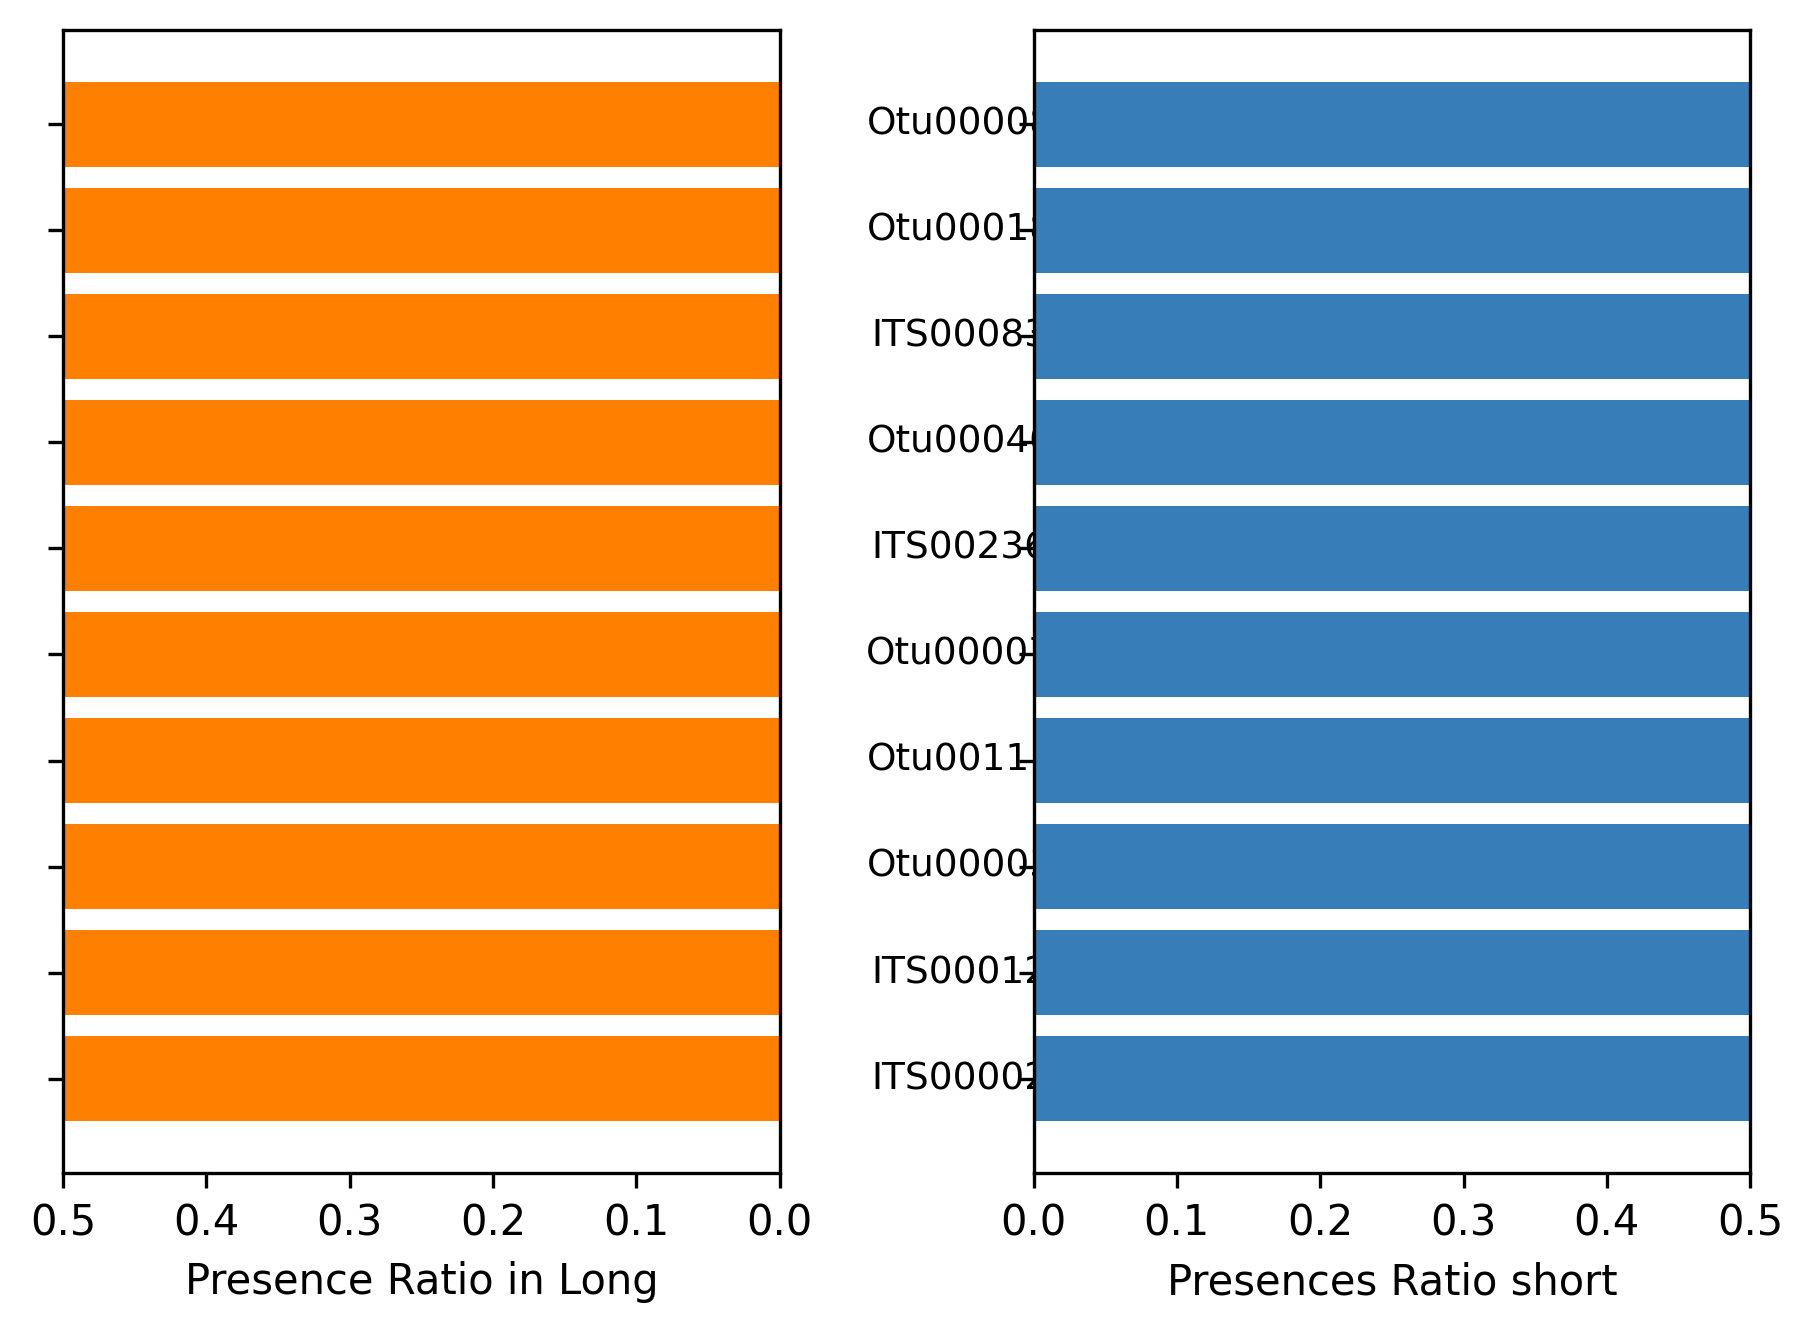

['Otu00024', 'ITS00045', 'ITS00012', 'Otu00007', 'ITS00236', 'ITS00050', 'ITS00002', 'Otu00006', 'ITS00211', 'Otu00274']
35 43


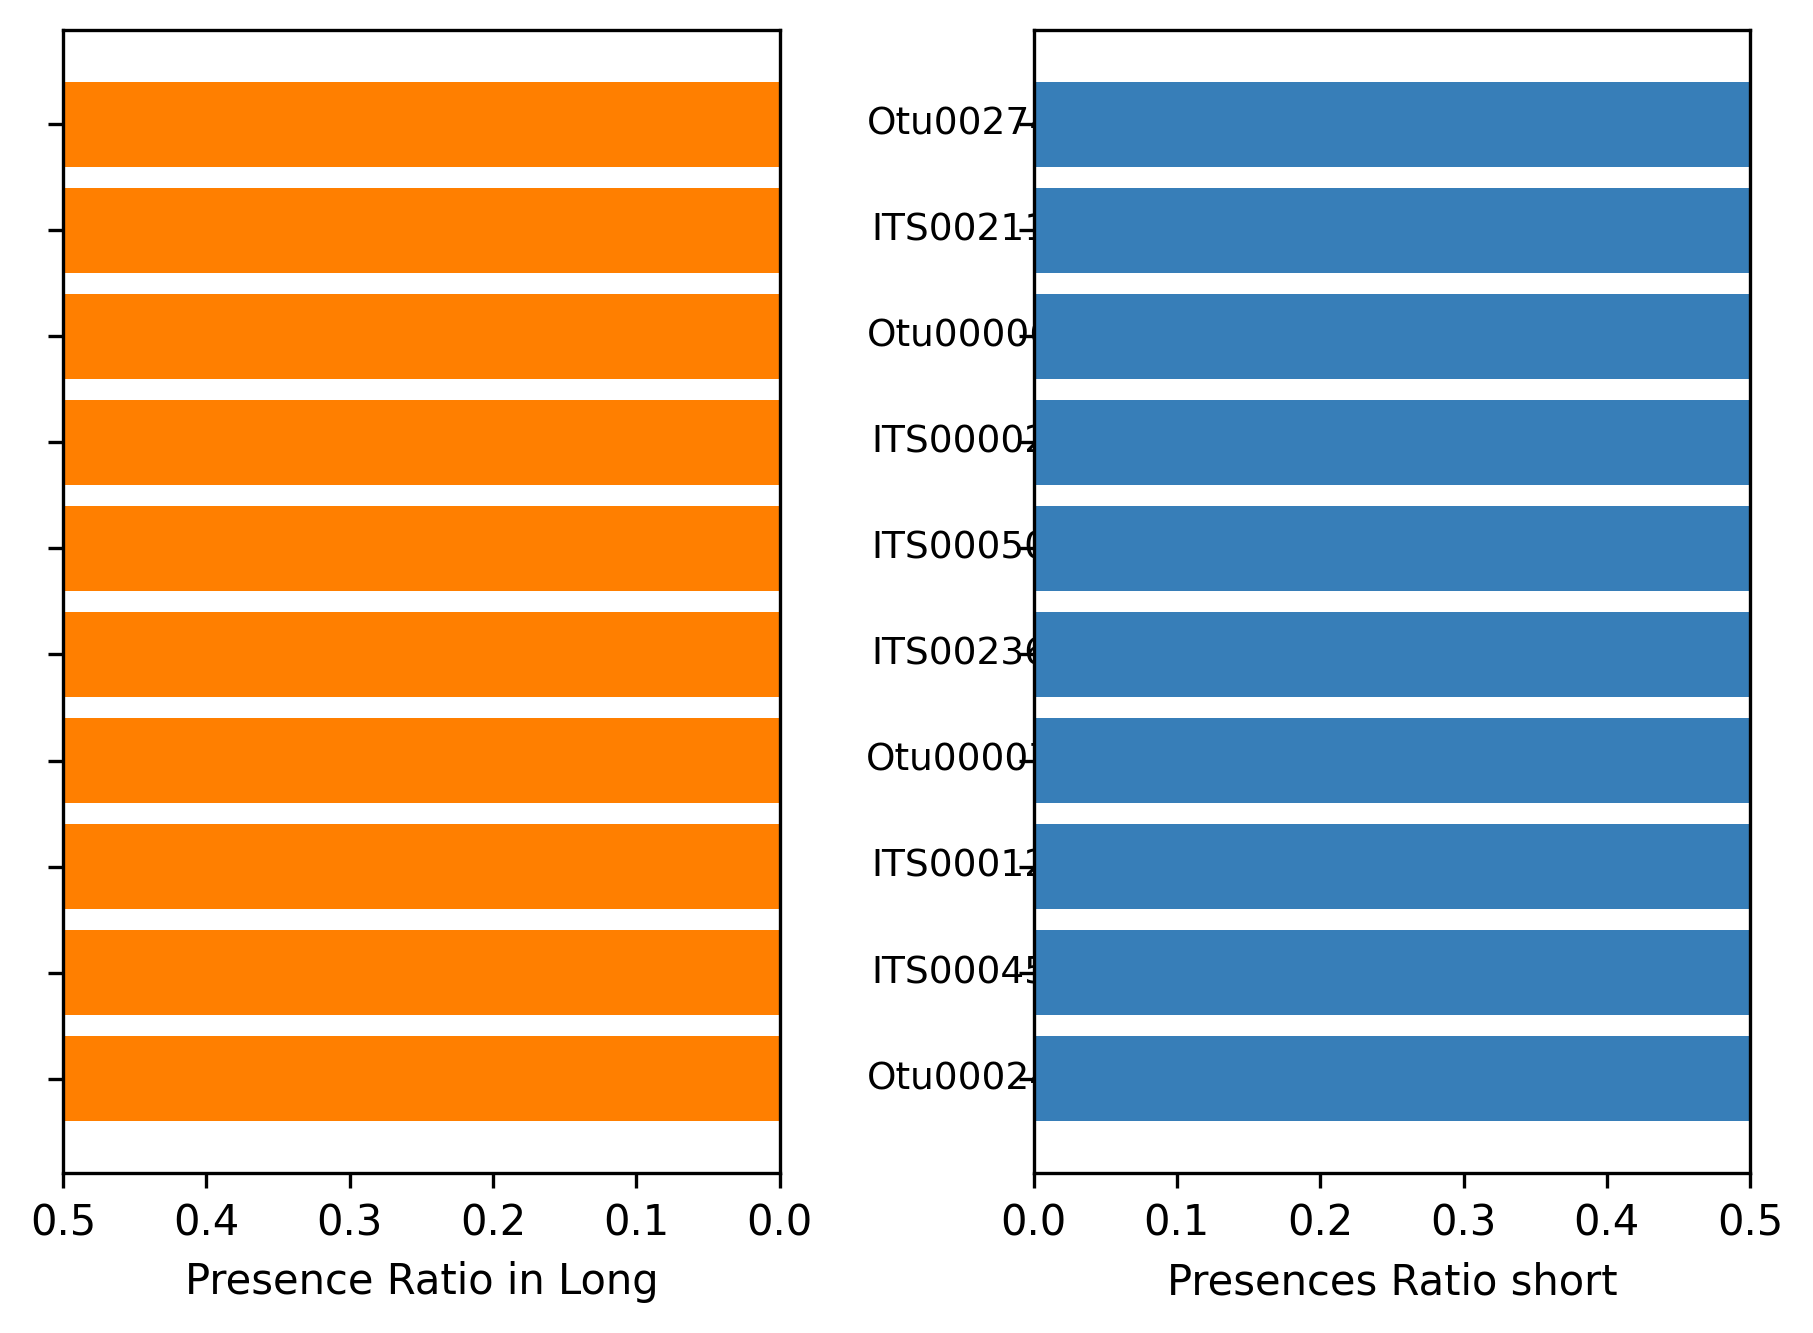

In [45]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

entries=10

for i, index in enumerate(selectedOTU_index_4tax):
    selectedOTU_index_15=index[:entries]
    #print(selectedOTU_index_15)
    selectedASVs_15=col_names_sig_sorted_4taxa[i][:entries]
    print(selectedASVs_15)
    X_FS_15=data_4taxa[i][:,selectedOTU_index_15]
    #df=pd.DataFrame(data=X_FS_15)
    RunML.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs_15,posLabel="LONG",posText="Long",negText="short",entries=entries)


['ASV81' 'ASV148' 'ASV66' 'ASV85' 'ASV73' 'ASV141' 'ASV38' 'ASV26' 'ASV15'
 'ASV3' 'ASV18' 'ASV43' 'ASV72' 'ASV111' 'ASV181' 'ASV139' 'ASV174'
 'ASV272' 'ASV263' 'ASV183' 'ASV231' 'ASV79' 'ASV208' 'ASV27' 'ASV19'
 'ASV51' 'ASV154' 'ASV39' 'ASV216' 'ASV13' 'ASV7' 'ASV225' 'ASV348'
 'ASV104' 'ASV338' 'ASV94' 'ASV237' 'ASV310' 'ASV179' 'ASV53' 'ASV91'
 'ASV315' 'ASV369' 'ASV133' 'ASV335' 'ASV114' 'ASV45' 'ASV5' 'ASV2'
 'ASV37' 'ASV191' 'ASV207' 'ASV274' 'ASV146' 'ASV99' 'ASV11' 'ASV1'
 'ASV24' 'ASV59' 'ASV227' 'ASV241' 'ASV270' 'ASV61' 'ASV52' 'ASV65'
 'ASV32' 'ASV150' 'ASV384' 'ASV129' 'ASV138' 'ASV180' 'ASV159' 'ASV30'
 'ASV8' 'ASV172' 'ASV110' 'ASV271' 'ASV122' 'ASV161' 'ASV54' 'ASV95'
 'ASV70' 'ASV276' 'ASV304' 'ASV250' 'ASV185']
86


### Negative Gini Impurity
Gini Impurity is the probability of incorrectly classifying a randomly chosen element in the dataset if it were randomly labeled according to the class distribution in the dataset. It’s calculated as:

$G = 1- \sum_{i=1}^C p_i^2$

where C is the number of classes. (which means it can be used to measure for multiple level classification)

Here I will use the negative Gini Impurity to measure each OTU, if NG is large (1) which means the OTU only exist in one class, if NG value is small($1/c$) which means the OTU is evenly distributed among  the classes.

$NG = \sum_{i=1}^C p_i^2$

In [38]:
len(data_4taxa)

4

In [34]:
np.unique(y, return_counts=True)

(array(['LONG', 'SHORT'], dtype='<U5'), array([35, 43]))

In [37]:
# NG for selected OTU

NG_4tax = []
for i, data  in enumerate(data_4taxa):
    X_FS = data[:,selectedOTU_index_4tax[i]]
    X_lasso = data[:,xlabel_lasso_4taxa[i]]
    NG_selected = metric.Neg_GINI(X_FS,y,cutOff=0.01)
    NG_Lasso = metric.Neg_GINI(X_lasso,y,cutOff=0.01)
    print(NG_selected.shape)
    print(NG_Lasso.shape)
    NG_4tax.append([NG_selected,NG_Lasso])

(23,)
(40,)
(26,)
(24,)
(34,)
(22,)
(13,)
(10,)


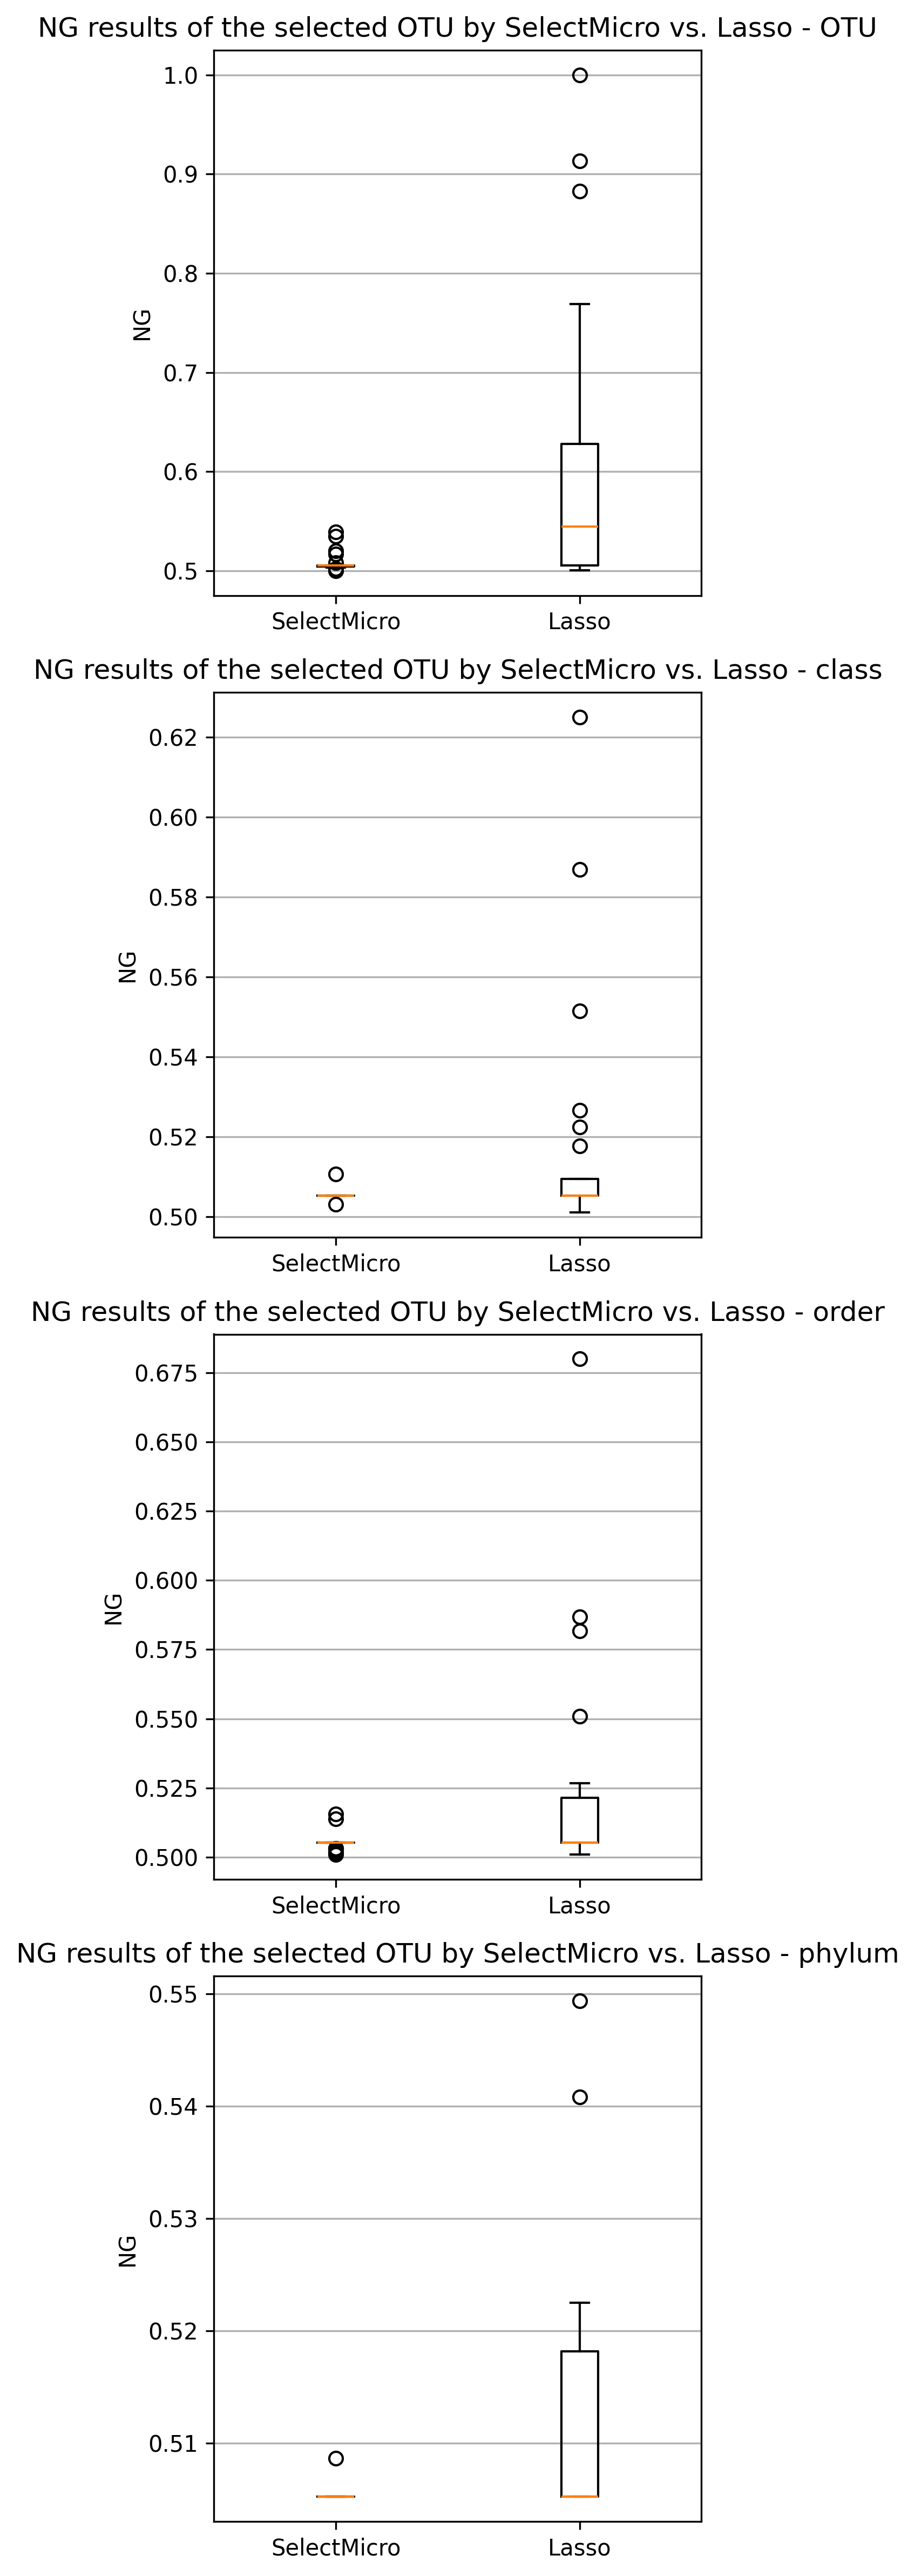

In [39]:
# compare the selected and non select by lasso
# Number of subplots
num_plots = len(data_4taxa)

# Create a figure with a grid of subplots
plt.figure(figsize=(4, 4 * num_plots))

# Loop through each index and create a subplot
for i in range(num_plots):
    plt.subplot(num_plots, 1, i + 1)  # (nrows, ncols, index)
    plt.boxplot([NG_4tax[i][0], NG_4tax[i][1]], tick_labels=['SelectMicro', 'Lasso'])
    plt.title(f'NG results of the selected OTU by SelectMicro vs. Lasso - {taxlabels[i]}')
    plt.ylabel('NG')
    plt.grid(axis='y')
# Adjust layout
plt.tight_layout()  # Adjusts the subplots to fit into the figure area.
plt.show()  # Show all plots at once